# Create boundary conditions for Mn extended


In [66]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import scipy.ndimage as ndimage
import matplotlib
import xarray as xr

%matplotlib inline

#### Files

In [67]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'])[0,:,:]
mbathy     = np.array(mesh.variables['tmask'])[0,:,:]
mesh_depth = np.array(mesh.variables['nav_lev'])
bathy_masked = np.ma.masked_where((mbathy> 0.1), mbathy)

In [68]:
m      = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2002_20211012/ANHA12_EXH006_2002_monthly.nc', 'r')
mdepth = np.array(m.variables['deptht'])
mlons  = np.array(m.variables['nav_lon'])
mlats  = np.array(m.variables['nav_lat'])

In [69]:
# Initial conditions
IC  = '/ocean/brogalla/GEOTRACES/data/Mn_ini_20210810.nc'
ICd = nc.Dataset(IC)
IC_dMn = np.array(ICd.variables['dMn'])[0,:,:,:]
IC_oMn = np.array(ICd.variables['oMn'])[0,:,:,:]

In [70]:
data = nc.Dataset('/data/brogalla/run_storage/test-extended_2022-09-27T153854.347084-0400/ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20020106-20020110.nc')
dmn = np.array(data.variables['dissolmn'])[0,:,:,:]

#### Parameters

In [71]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax-imin
jsize = jmax-jmin

# Rimwidths:
rimwidthS  = 10
rimwidthW  = 10

# Boundary coordinates: (i1,i2,j1,j2)
S_coordinates = (1140,1150,446,672) # Baffin Bay
W_coordinates = (1190,1472,291,301) # Hudson Bay

# Colours:
land_color = '#a9a7a2'

#### Functions

In [8]:
def flatten_input(var, order):
    b = var[0,:,:].flatten(order=order)
    for i in range(1,len(var)):
        a = var[i,:,:].flatten(order=order)
        b = np.vstack((b,a))
    return b

In [9]:
def create_boundary(rimwidth, boundary_dMn, boundary_oMn, order):
    
    dMn_O = flatten_input(boundary_dMn, order)
    oMn_O = flatten_input(boundary_oMn, order)
    
    dMn_OBC = np.reshape(dMn_O, (1,50,1,np.max(boundary_dMn.shape)*rimwidth))
    oMn_OBC = np.reshape(oMn_O, (1,50,1,np.max(boundary_dMn.shape)*rimwidth))

    return dMn_OBC, oMn_OBC

In [10]:
def save_BC_file(name, dMn_BC, oMn_BC):
    # Setup the new NetCDF file:
    ncd = nc.Dataset(f'/ocean/brogalla/GEOTRACES/data/{name}', 'w', zlib=True)
    ncd.createDimension('x', np.max(dMn_BC.shape))
    ncd.createDimension('y',1)
    ncd.createDimension('z',50)
    ncd.createDimension('t',None)
    
    print(np.max(dMn_BC.shape))
    
    dMn = ncd.createVariable('dMn', 'float64', ('t','z','y','x'))
    dMn.units = 'mol/L'
    dMn.long_name = 'dissolved Mn'
    dMn[:] = dMn_BC

    oMn = ncd.createVariable('oMn', 'float64', ('t','z','y','x'))
    oMn.units = 'mol/L'
    oMn.long_name = 'oxidised Mn'
    oMn[:] = oMn_BC
    
    ncd.close()
    return

#### Create boundary conditions:

In [64]:
# Create global model based boundary condition
dMn_west_IC  = IC_dMn[:,W_coordinates[0]:W_coordinates[1],W_coordinates[2]:W_coordinates[3]]
oMn_west_IC  = IC_oMn[:,W_coordinates[0]:W_coordinates[1],W_coordinates[2]:W_coordinates[3]]

dMn_south_IC = IC_dMn[:,S_coordinates[0]:S_coordinates[1],S_coordinates[2]:S_coordinates[3]]
oMn_south_IC = IC_oMn[:,S_coordinates[0]:S_coordinates[1],S_coordinates[2]:S_coordinates[3]]

dMn_west_BC , oMn_west_BC  = create_boundary(rimwidthW , dMn_west_IC , oMn_west_IC , 'F')
dMn_south_BC, oMn_south_BC = create_boundary(rimwidthS, dMn_south_IC, oMn_south_IC, 'C')

In [65]:
# Save boundary conditions to file:
save_BC_file('Mn_South_OBC-extended-20220927.nc', dMn_south_BC, oMn_south_BC)
save_BC_file('Mn_West_OBC-extended-20220927.nc', dMn_west_BC, oMn_west_BC)

2260
2820


In [89]:
def plot_boundary_transect_W(bdy_coordinates, dMn_new, oMn_new, layer, ylim=(4000,0)):
    
    (bdyimin, bdyimax, bdyjmin, bdyjmax) = bdy_coordinates
    
    # Latitude of boundary:
    lats_bdy = mesh_lat[bdyimin:bdyimax,bdyjmin:bdyjmax]
    lons_bdy = mesh_lon[bdyimin:bdyimax,bdyjmin:bdyjmax]
    mesh_bathy_bdy = bathy_masked[:,bdyimin:bdyimax,bdyjmin+layer]
    lats           = lats_bdy[:,layer]
    lons           = lons_bdy[:,layer]
    print(lons.shape, mesh_depth.shape, dMn_new[:,:,:].shape, oMn_new[:,:,:].shape)
    
    ### Figure:
    fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=300)
        
    # new boundaries (bottom panels): 
    CB1 = ax[0].pcolormesh(lats, mesh_depth, dMn_new[:,:,layer]*1e9, vmin=0, vmax=6, cmap=cmocean.cm.dense, zorder=1)
    CB2 = ax[1].pcolormesh(lats, mesh_depth, oMn_new[:,:,layer]*1e9, vmin=0, vmax=6, cmap=cmocean.cm.dense, zorder=1)
    
    # labels
    ax[0].set_ylabel('Depth', fontsize=7)
    ax[1].set_ylabel('Depth', fontsize=7)
    ax[0].set_xlabel('Degrees North', fontsize=7)
    ax[1].set_xlabel('Degrees North', fontsize=7)
    ax[0].set_title("Dissolved Mn", fontsize=7)
    ax[1].set_title("Oxidised Mn", fontsize=7)
    
    for axes in ax.flatten():
        axes.invert_yaxis()
        axes.pcolormesh(lats, mesh_depth, mesh_bathy_bdy, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)
        axes.set_ylim(ylim[0],ylim[1])
        axes.tick_params(axis='both', labelsize=7)
        
    # colorbars:
    cbar_ax1 = fig.add_axes([0.14, 0.25, 0.03, 0.26])
    cbar_ax2 = fig.add_axes([0.56, 0.25, 0.03, 0.26])
        
    cbar1 = plt.colorbar(CB1, cax=cbar_ax1)
    cbar2 = plt.colorbar(CB2, cax=cbar_ax2)
    
    for cbar in [cbar1, cbar2]:
        cbar.ax.tick_params(labelsize=7) 
    return

In [77]:
def plot_boundary_transect_S(bdy_coordinates, dMn_new, oMn_new, layer, ylim=(4000,0)):
    
    (bdyimin, bdyimax, bdyjmin, bdyjmax) = bdy_coordinates
    
    # Latitude of boundary:
    lats_bdy = mesh_lat[bdyimin:bdyimax,bdyjmin:bdyjmax]
    lons_bdy = mesh_lon[bdyimin:bdyimax,bdyjmin:bdyjmax]
    mesh_bathy_bdy = bathy_masked[:,bdyimin+layer,bdyjmin:bdyjmax]
    lons           = lons_bdy[layer,:]
    print(lons.shape, mesh_depth.shape, dMn_new[:,:,:].shape, oMn_new[:,:,:].shape)
    
    ### Figure:
    fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=300)
        
    # new boundaries (bottom panels): 
    CB1 = ax[0].pcolormesh(lons, mesh_depth, dMn_new[:,layer,:]*1e9, vmin=0, vmax=4, cmap=cmocean.cm.dense, zorder=1)
    CB2 = ax[1].pcolormesh(lons, mesh_depth, oMn_new[:,layer,:]*1e9, vmin=0, vmax=4, cmap=cmocean.cm.dense, zorder=1)
    
    # labels
    ax[0].set_ylabel('Depth', fontsize=7)
    ax[1].set_ylabel('Depth', fontsize=7)
    ax[0].set_xlabel('Degrees North', fontsize=7)
    ax[1].set_xlabel('Degrees North', fontsize=7)
    ax[0].set_title("Dissolved Mn", fontsize=7)
    ax[1].set_title("Oxidised Mn", fontsize=7)
    
    for axes in ax.flatten():
        axes.invert_yaxis()
        axes.pcolormesh(lons, mesh_depth, mesh_bathy_bdy, cmap=matplotlib.colors.ListedColormap([land_color]), zorder=2)
        axes.set_ylim(ylim[0],ylim[1])
        axes.tick_params(axis='both', labelsize=7)
        
    # colorbars:
    cbar_ax1 = fig.add_axes([0.14, 0.25, 0.03, 0.26])
    cbar_ax2 = fig.add_axes([0.56, 0.25, 0.03, 0.26])
        
    cbar1 = plt.colorbar(CB1, cax=cbar_ax1)
    cbar2 = plt.colorbar(CB2, cax=cbar_ax2)
    
    for cbar in [cbar1, cbar2]:
        cbar.ax.tick_params(labelsize=7) 
    return

In [75]:
S_coordinates

(1140, 1150, 446, 672)

(226,) (50,) (50, 10, 226) (50, 10, 226)


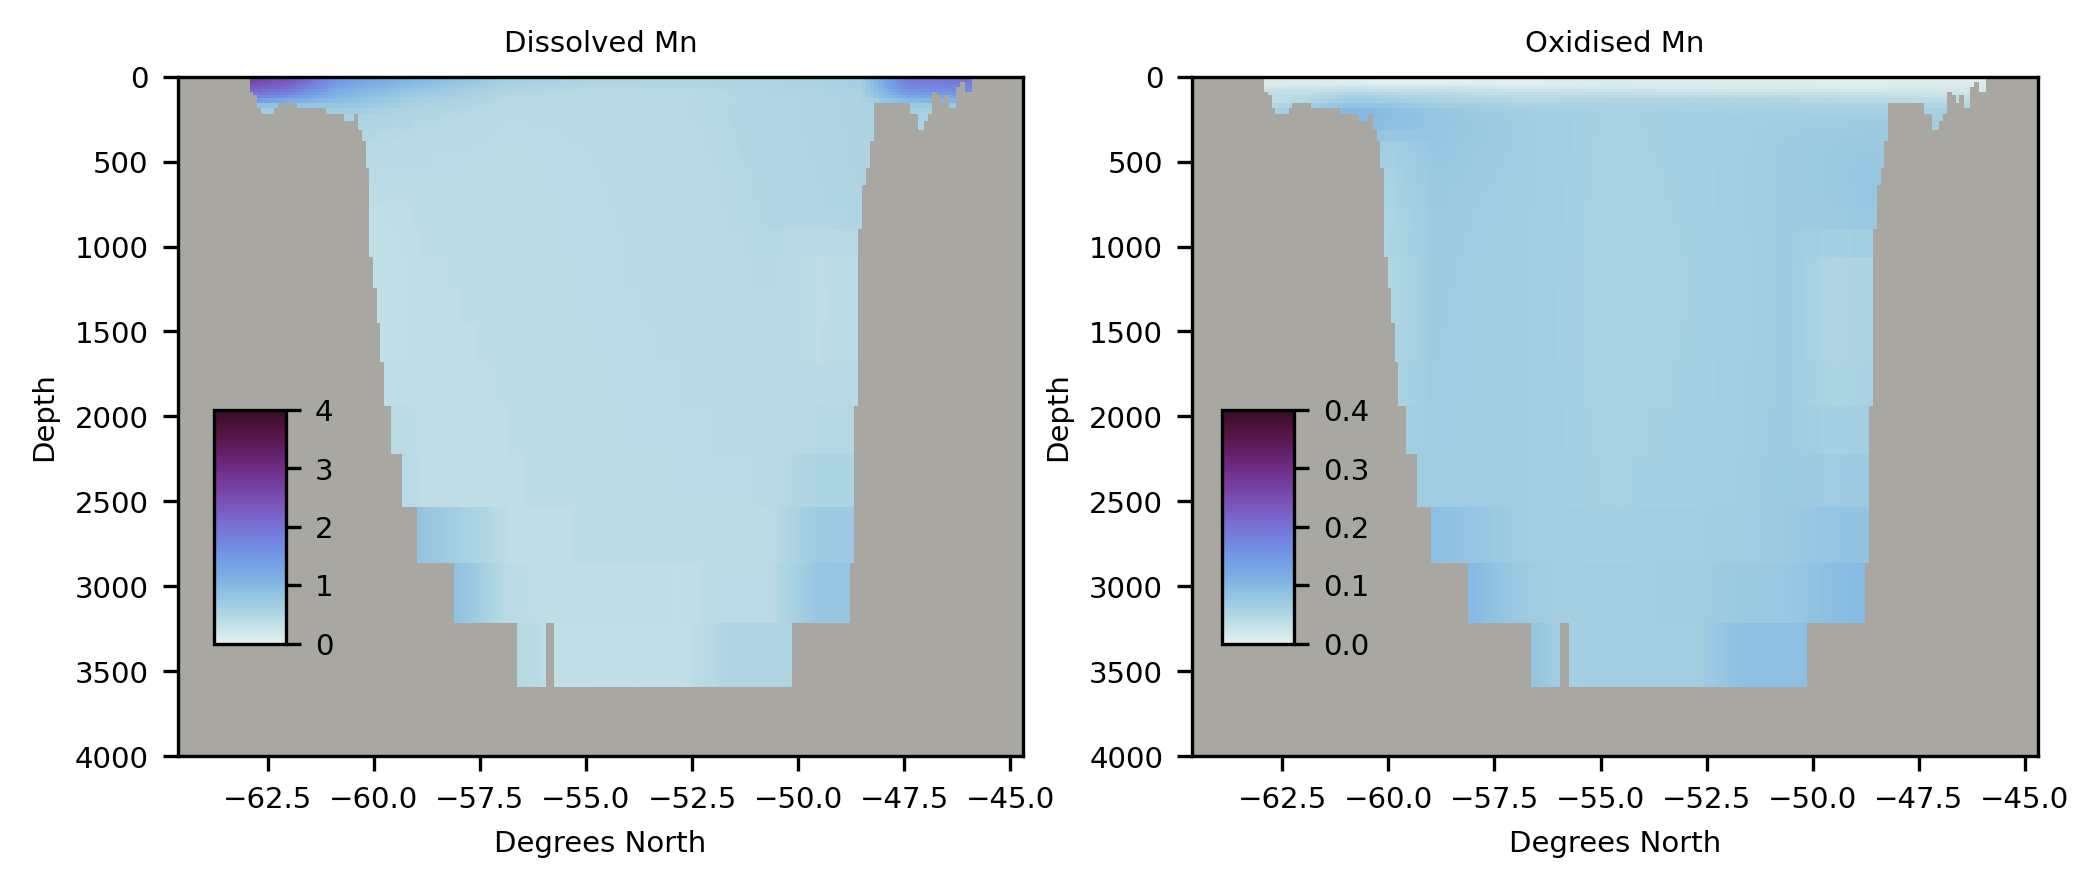

In [60]:
plot_boundary_transect_S(S_coordinates, dMn_south_IC, oMn_south_IC, 4, ylim=(4000,0))

(282,) (50,) (50, 282, 10) (50, 282, 10)


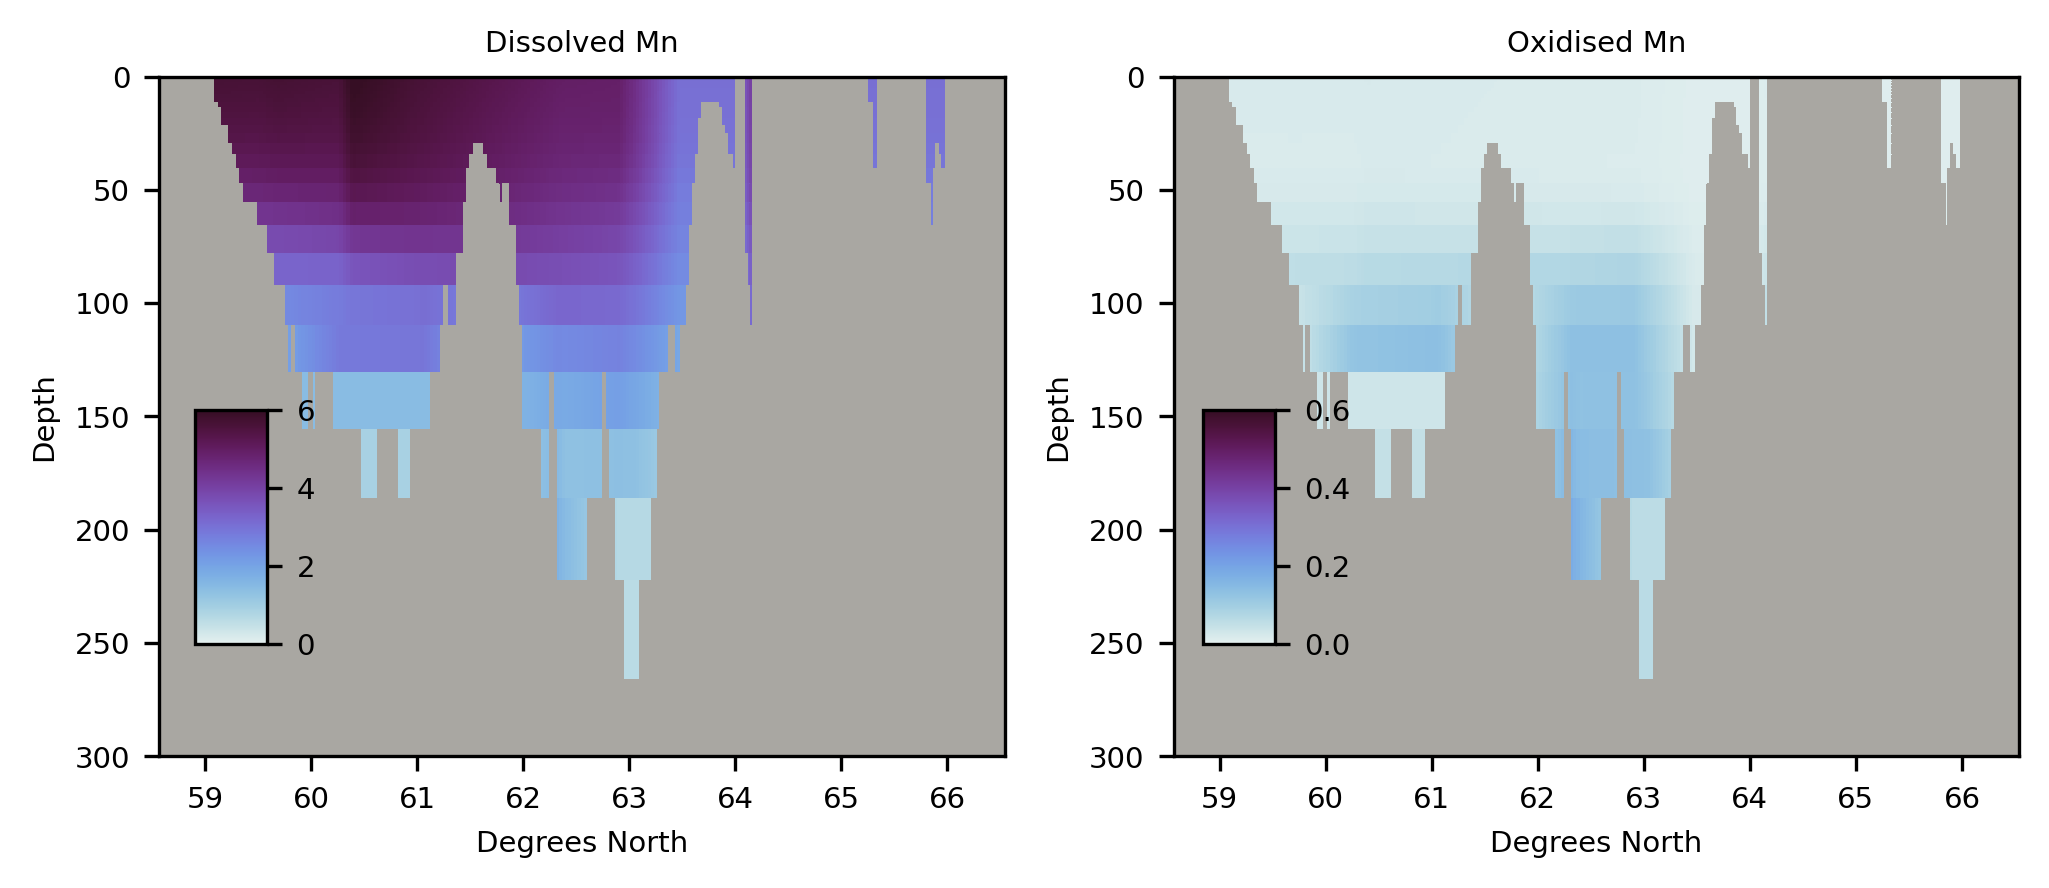

In [63]:
plot_boundary_transect_W(W_coordinates, dMn_west_IC, oMn_west_IC, 1, ylim=(300,0))